### Import Packages

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, exists
import pymysql

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle


### Cleaning data

#### Connect to database

In [2]:
# Read sensitive information from environment variables
api_key = os.getenv('OPENWEATHERMAP_API_KEY', "5b103a5aa9cd52cd178d63c3c83ad6ec")
db_username = os.getenv('DB_USERNAME', 'admin')
db_password = os.getenv('DB_PASSWORD', 'qwerty123')
db_name = os.getenv('DB_NAME', 'dublinbikes')
db_endpoint = os.getenv('DB_ENDPOINT', 'dublinbikes.ch2g8eocy1o4.eu-west-1.rds.amazonaws.com')
db_port = os.getenv('DB_PORT', '3306')


# Construct the database connection URL, using pymysql as the driver for the MySQL database
database_url = f"mysql+pymysql://{db_username}:{db_password}@{db_endpoint}:{db_port}/{db_name}"

# Attempt to create the database engine and connect
try:
    db = create_engine(database_url)
    conn = db.connect()
    print("Connected to the database successfully.")

except Exception as e:
    print(f"An error occurred: {e}")

Connected to the database successfully.


#### Get data

In [3]:
# withdraw data
query_station = "SELECT * FROM station"
query_availability = "SELECT * FROM availability"
query_weather = "SELECT * FROM weather"

df_station = pd.read_sql_query(query_station, db)
df_availability = pd.read_sql_query(query_availability, db)
df_weather = pd.read_sql_query(query_weather, db)

#### Weather Table

In [4]:
# 1. check data
print(df_weather.head())
print(df_weather.info())
print(df_weather.describe())

# 2. clean data
# only save columns we need
columns_to_keep = ['weather_main', 'weather_description', 'temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'last_update']
df_weather = df_weather[columns_to_keep]
# delete duplicate rows
df_weather.drop_duplicates(inplace=True)

# Fill in or remove missing values (here, the choice is to remove rows that contain any missing values).
df_weather.dropna(inplace=True)

   number weather_main weather_description  weather_id weather_icon  \
0       1       Clouds       broken clouds         803          04n   
1       2       Clouds    scattered clouds         802          03n   
2       3       Clouds    scattered clouds         802          03n   
3       4       Clouds       broken clouds         803          04n   
4       5       Clouds    scattered clouds         802          03n   

   position_lat  position_long  temperature  feels_like  temp_min  ...  \
0        53.344        -6.2672       279.58      277.69    278.51  ...   
1        53.344        -6.2672       279.39      276.21    278.51  ...   
2        53.344        -6.2672       279.34      276.15    277.58  ...   
3        53.344        -6.2672       279.58      277.69    278.51  ...   
4        53.344        -6.2672       279.34      276.15    277.58  ...   

          last_update  sys_type   sys_id  sys_country         sys_sunrise  \
0 2024-02-27 23:15:21       2.0  2016139           

In [5]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1814 entries, 0 to 1816
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1814 non-null   object        
 1   weather_description  1814 non-null   object        
 2   temperature          1814 non-null   float64       
 3   feels_like           1814 non-null   float64       
 4   pressure             1814 non-null   float64       
 5   humidity             1814 non-null   float64       
 6   visibility           1814 non-null   float64       
 7   wind_speed           1814 non-null   float64       
 8   wind_deg             1814 non-null   float64       
 9   clouds_all           1814 non-null   float64       
 10  last_update          1814 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 170.1+ KB
None


#### Station Table

In [6]:
# 1. check data
print(df_station.head())
print(df_station.info())
print(df_station.describe())

# 2. clean data
# only save columns we need
columns_to_keep_station = ['number', 'name', 'address', 'position_lat', 'position_long', 'bike_stands']
df_station = df_station[columns_to_keep_station]

# delete duplicate rows
df_station.drop_duplicates(inplace=True)

              address  banking  bike_stands  bonus contract_name  \
0       Clarendon Row        0           31      0        dublin   
1  Blessington Street        0           20      0        dublin   
2       Bolton Street        0           20      0        dublin   
3        Greek Street        0           20      0        dublin   
4   Charlemont Street        0           40      0        dublin   

                 name  number  position_lat  position_long  
0       CLARENDON ROW       1     53.340927      -6.262501  
1  BLESSINGTON STREET       2     53.356769      -6.268140  
2       BOLTON STREET       3     53.351182      -6.269859  
3        GREEK STREET       4     53.346874      -6.272976  
4    CHARLEMONT PLACE       5     53.330662      -6.260177  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        114 non-null 

In [7]:
print(df_station.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   number         114 non-null    int64  
 1   name           114 non-null    object 
 2   address        114 non-null    object 
 3   position_lat   114 non-null    float64
 4   position_long  114 non-null    float64
 5   bike_stands    114 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.5+ KB
None


#### Availibility Table

In [8]:
# 1. check data
print(df_availability.head())
print(df_availability.info())
print(df_availability.describe())

# 2. clean
# Fill in or remove missing values.
# For dynamic data, ensure there is no missing key information, such as available\_bikes. Here, we choose to remove rows that contain any missing values.
df_availability.dropna(inplace=True)

# Remove unnecessary columns
# We decide to keep the station number, the number of available bikes, the number of available slots, and the last update time.
columns_to_keep_availability = ['number', 'available_bikes', 'available_bike_stands', 'last_update']
df_availability = df_availability[columns_to_keep_availability]

df_availability.drop_duplicates(inplace=True)

   id  number  available_bikes  available_bike_stands         last_update  \
0   1      42               29                      1 2024-02-18 05:12:40   
1   2      30                8                     12 2024-02-18 05:10:22   
2   3      54               15                     18 2024-02-18 05:09:23   
3   4     108               15                     20 2024-02-18 05:08:23   
4   5      20                0                     30 2024-02-18 05:10:51   

  status  
0   OPEN  
1   OPEN  
2   OPEN  
3   OPEN  
4   OPEN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1731660 entries, 0 to 1731659
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   number                 int64         
 2   available_bikes        int64         
 3   available_bike_stands  int64         
 4   last_update            datetime64[ns]
 5   status                 object        
dtypes: datetim

In [9]:
print(df_availability.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1066637 entries, 0 to 1731659
Data columns (total 4 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   number                 1066637 non-null  int64         
 1   available_bikes        1066637 non-null  int64         
 2   available_bike_stands  1066637 non-null  int64         
 3   last_update            1066637 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 40.7 MB
None


Make sure we start from the same date

In [10]:
# make sure the format
df_weather['last_update'] = pd.to_datetime(df_weather['last_update'])

# keep the data after 2024-02-28
df_weather_filtered = df_weather[df_weather['last_update'] >= '2024-02-28']


In [11]:
# make sure the format
df_availability['last_update'] = pd.to_datetime(df_availability['last_update'])

# keep the data after 2024-02-28
df_availability_filtered = df_availability[df_availability['last_update'] >= '2024-02-28']


Check again

In [12]:
print(df_availability_filtered.info())
print(df_weather_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 880007 entries, 295841 to 1731659
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 880007 non-null  int64         
 1   available_bikes        880007 non-null  int64         
 2   available_bike_stands  880007 non-null  int64         
 3   last_update            880007 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 33.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1809 entries, 8 to 1816
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   weather_main         1809 non-null   object        
 1   weather_description  1809 non-null   object        
 2   temperature          1809 non-null   float64       
 3   feels_like           1809 non-null   float64       
 4   pressure         

In [13]:
# we only have 117 stations so should keep number between 1 and 117(include)
df_availability_filtered = df_availability_filtered[(df_availability_filtered['number'] >= 1) & (df_availability_filtered['number'] <= 117)]
print(df_availability_filtered.shape)
print(df_availability_filtered.sample(5))  # print 5 rows to check data


(880007, 4)
         number  available_bikes  available_bike_stands         last_update
580346       26               12                      8 2024-03-07 16:40:01
949311       99                1                     29 2024-03-18 23:39:47
1351477      18               19                     11 2024-03-31 06:59:37
1447624      58                5                     35 2024-04-03 05:29:14
942234       90                4                     36 2024-03-18 18:28:28


#### Calculated outlier

In [14]:
print("Availability Statistical Summary:")
print(df_availability_filtered[['available_bikes', 'available_bike_stands']].describe())

Availability Statistical Summary:
       available_bikes  available_bike_stands
count    880007.000000          880007.000000
mean         12.000084              19.872703
std           9.893770              11.110627
min           0.000000               0.000000
25%           3.000000              11.000000
50%          10.000000              20.000000
75%          19.000000              29.000000
max          40.000000              40.000000


Availability dataset observations: 
Available bikes (available_bikes): Average is about 12.3, with a standard deviation close to 10, indicating that the number of available bikes varies significantly between sites. The minimum value is 0 (no available bikes), and the maximum value is 40 (possibly the maximum capacity of some sites). Available parking spaces (available_bike_stands): Average is about 19.5, with a standard deviation of about 11.2, similar to the distribution of available bikes, indicating that the availability of parking spaces also varies significantly. The minimum and maximum values are also 0 and 40, consistent with the maximum value of bikes.致。

In [15]:
print("\nWeather Statistical Summary:")
# Update reserved numeric columns
weather_numerical_columns = ['temperature', 'feels_like', 'pressure', 'humidity', 'visibility', 'wind_speed', 'wind_deg', 'clouds_all']
print(df_weather_filtered[weather_numerical_columns].describe())


Weather Statistical Summary:
       temperature   feels_like     pressure     humidity    visibility  \
count  1809.000000  1809.000000  1809.000000  1809.000000   1809.000000   
mean    282.459701   280.280520  1000.499724    82.776119   9218.630182   
std       2.889756     4.103664    12.696819     8.476357   1744.235406   
min     274.240000   268.230000   968.000000    52.000000   1500.000000   
25%     280.500000   277.260000   993.000000    77.000000  10000.000000   
50%     282.030000   279.380000  1000.000000    84.000000  10000.000000   
75%     284.490000   283.710000  1010.000000    90.000000  10000.000000   
max     291.610000   291.310000  1024.000000    98.000000  10000.000000   

        wind_speed     wind_deg   clouds_all  
count  1809.000000  1809.000000  1809.000000  
mean      6.309768   175.621338    64.745163  
std       2.881986    80.658235    19.862017  
min       0.170000     0.000000     0.000000  
25%       4.120000   110.000000    75.000000  
50%       6.

temperature: 
1. The mean temperature is about 282.03K (about 8.88°C), and the standard deviation is about 2.61K, indicating that the temperature is relatively stable during the observation period. The temperature ranges from 274.24K (about 1.09°C) to 288.63K (about 15.48°C). 
2. feels_like: The average feels_like temperature is slightly lower than the actual temperature, which is expected because the feels_like temperature is affected by wind speed and humidity. 
3. pressure: The average pressure is about 999.84 hpa, and the pressure varies from 968 to 1024 hpa, indicating that the pressure change is not very large during the observation period. 
The average humidity was high, about 83.53%, indicating that the weather was humid during the observation period. 
4. visibility: The average visibility is 9165.19 meters, and some data reaches the maximum of 10,000 meters (which may be the upper limit of the data), indicating good visibility most of the time. 
5. Wind speed (wind_speed): The average wind speed is about 5.96 m/s, and the wind speed varies from 0.17 to 14.4 m/s, indicating that the wind speed is sometimes relatively high.对较高。致。

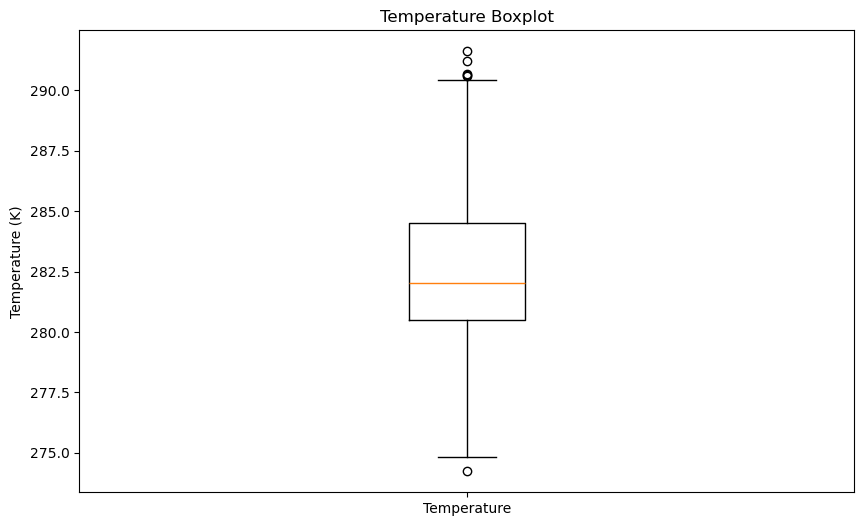

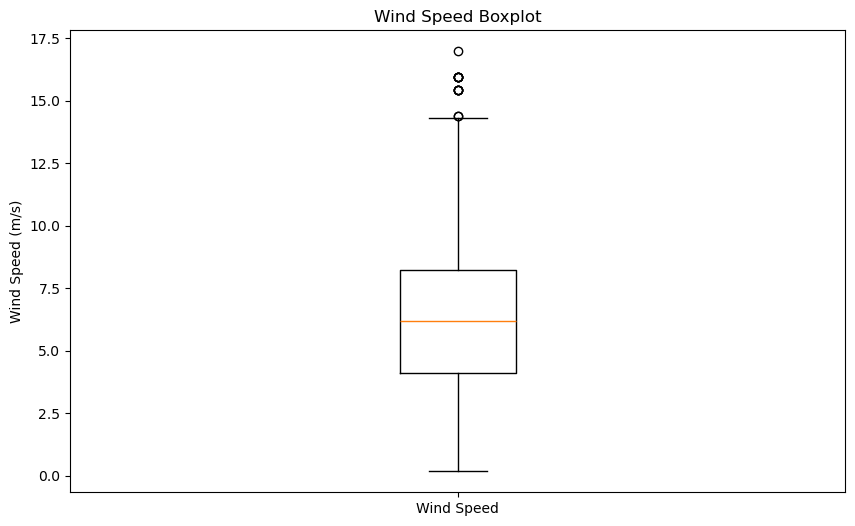

In [16]:
# Box diagram of temperature
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['temperature'].dropna())
plt.title('Temperature Boxplot')
plt.ylabel('Temperature (K)')
plt.xticks([1], ['Temperature'])
plt.show()

# Box diagram of windSpeed
plt.figure(figsize=(10, 6))
plt.boxplot(df_weather_filtered['wind_speed'].dropna())
plt.title('Wind Speed Boxplot')
plt.ylabel('Wind Speed (m/s)')
plt.xticks([1], ['Wind Speed'])
plt.show()


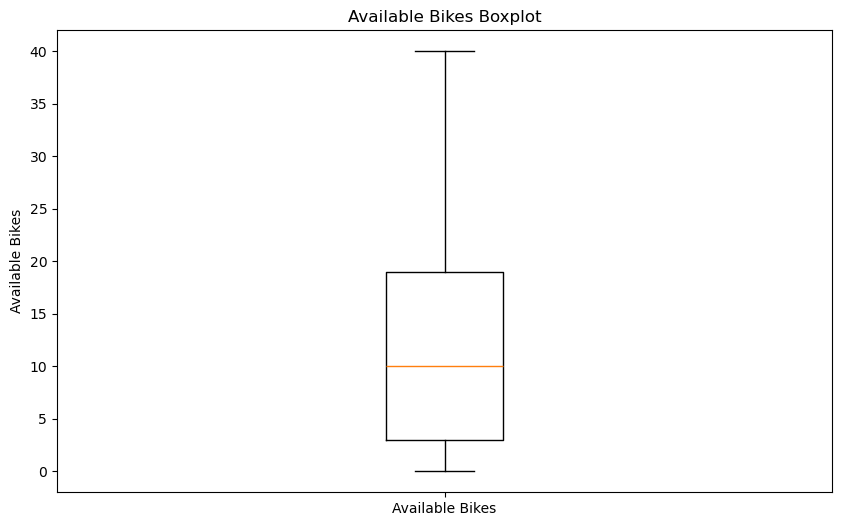

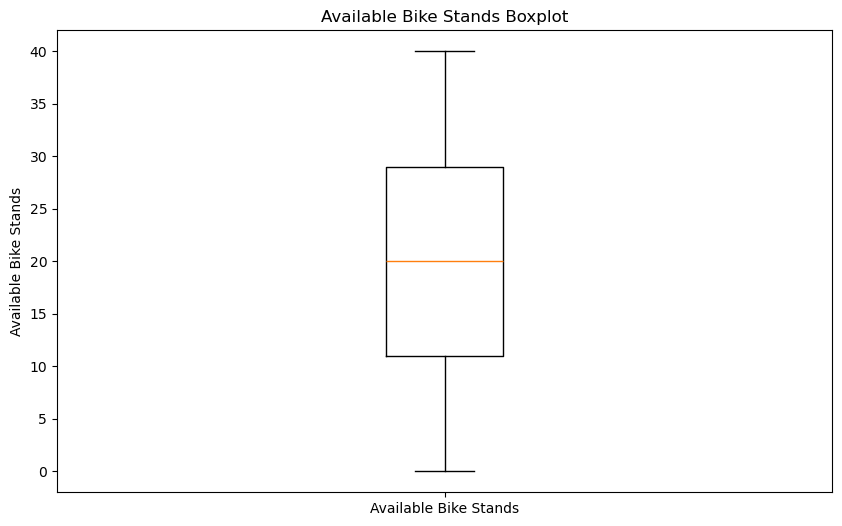

In [17]:
# The box diagram of the bicycle is available
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bikes'].dropna())
plt.title('Available Bikes Boxplot')
plt.ylabel('Available Bikes')
plt.xticks([1], ['Available Bikes'])
plt.show()

# Box map of available parking Spaces
plt.figure(figsize=(10, 6))
plt.boxplot(df_availability_filtered['available_bike_stands'].dropna())
plt.title('Available Bike Stands Boxplot')
plt.ylabel('Available Bike Stands')
plt.xticks([1], ['Available Bike Stands'])
plt.show()


All good!!!! 

In order to more accurately match weather conditions, the weather data is temporally interpolated to create a denser time series dataset. Next, the interpolated weather data was combined with the bike availability data by last_update and number (station number). In this way, each bike data point will have a corresponding weather condition.况。

In [18]:
# Defines a list of category type columns
category_columns = ['weather_main', 'weather_description']

# Make sure the 'last_update' column is part of the DataFrame
if 'last_update' not in df_weather_filtered.columns:
    df_weather_filtered = df_weather_filtered.reset_index()

# Convert 'last_update' to the datetime type, where.loc is used to avoid SettingWithCopyWarning
df_weather_filtered.loc[:, 'last_update'] = pd.to_datetime(df_weather_filtered.loc[:, 'last_update'])

# Select numeric columns for interpolation
df_weather_numerical = df_weather_filtered.set_index('last_update')[weather_numerical_columns]
df_weather_interpolated = df_weather_numerical.interpolate(method='time').reset_index()

# Use.ffill() directly for forward fill to avoid FutureWarning
df_weather_filtered.loc[:, category_columns] = df_weather_filtered.loc[:, category_columns].ffill()

# Merge the categorical data back into the interpolated numerical data
df_weather_final = pd.merge(df_weather_interpolated, df_weather_filtered.loc[:, ['last_update'] + category_columns].drop_duplicates(), on='last_update', how='left')

# show the result to check
print(df_weather_final.head())


          last_update  temperature  feels_like  pressure  humidity  \
0 2024-02-28 00:26:21       278.85      276.10    1018.0      80.0   
1 2024-02-28 00:55:00       278.87      276.13    1018.0      80.0   
2 2024-02-28 01:27:46       278.97      276.58    1018.0      80.0   
3 2024-02-28 01:58:16       279.26      276.93    1017.0      80.0   
4 2024-02-28 02:27:23       279.29      276.64    1017.0      80.0   

   visibility  wind_speed  wind_deg  clouds_all weather_main  \
0     10000.0        3.60     210.0        40.0       Clouds   
1     10000.0        3.60     210.0        40.0       Clouds   
2     10000.0        3.09     200.0        40.0       Clouds   
3     10000.0        3.09     200.0        75.0         Rain   
4     10000.0        3.60     210.0        75.0         Rain   

  weather_description  
0    scattered clouds  
1    scattered clouds  
2    scattered clouds  
3          light rain  
4          light rain  


In [19]:
# Sort the two Dataframes by last_update
df_availability_sorted = df_availability_filtered.sort_values('last_update')
df_weather_sorted = df_weather_final.sort_values('last_update')

# Use merge_asof to find the most recent time record to merge
# We use nearest, so that the nearest can be found regardless of whether the timestamp is first or last
df_combined = pd.merge_asof(df_availability_sorted, df_weather_sorted,
                            on='last_update', direction='nearest')

print(df_combined.head())


   number  available_bikes  available_bike_stands         last_update  \
0      13                0                     30 2024-02-28 00:00:00   
1      59                7                     13 2024-02-28 00:00:02   
2     103                8                     32 2024-02-28 00:00:02   
3      73                7                     23 2024-02-28 00:00:06   
4      22               10                     10 2024-02-28 00:00:07   

   temperature  feels_like  pressure  humidity  visibility  wind_speed  \
0       278.85       276.1    1018.0      80.0     10000.0         3.6   
1       278.85       276.1    1018.0      80.0     10000.0         3.6   
2       278.85       276.1    1018.0      80.0     10000.0         3.6   
3       278.85       276.1    1018.0      80.0     10000.0         3.6   
4       278.85       276.1    1018.0      80.0     10000.0         3.6   

   wind_deg  clouds_all weather_main weather_description  
0     210.0        40.0       Clouds    scattered clouds 

In [20]:
# Print 5 random rows of data for verification
print(df_combined.sample(5))

        number  available_bikes  available_bike_stands         last_update  \
852167     117               14                     25 2024-04-10 12:22:08   
520754     112                4                     26 2024-03-24 23:37:45   
473583      79                0                     27 2024-03-22 13:44:07   
719378      71                8                     32 2024-04-03 20:25:45   
227475      50               38                      2 2024-03-10 10:23:20   

        temperature  feels_like  pressure  humidity  visibility  wind_speed  \
852167       289.24      289.07    1013.0      83.0     10000.0        8.75   
520754       281.00      277.26    1000.0      93.0      4000.0        7.20   
473583       284.44      283.14    1017.0      58.0     10000.0       11.62   
719378       283.05      282.18     999.0      82.0     10000.0        2.06   
227475       280.36      276.98     996.0      83.0      2500.0        5.66   

        wind_deg  clouds_all weather_main weather_descri

In [21]:
print(df_combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880007 entries, 0 to 880006
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 880007 non-null  int64         
 1   available_bikes        880007 non-null  int64         
 2   available_bike_stands  880007 non-null  int64         
 3   last_update            880007 non-null  datetime64[ns]
 4   temperature            880007 non-null  float64       
 5   feels_like             880007 non-null  float64       
 6   pressure               880007 non-null  float64       
 7   humidity               880007 non-null  float64       
 8   visibility             880007 non-null  float64       
 9   wind_speed             880007 non-null  float64       
 10  wind_deg               880007 non-null  float64       
 11  clouds_all             880007 non-null  float64       
 12  weather_main           880007 non-null  obje

### EDA

E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
E:\jupyter\envs\comp30830\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


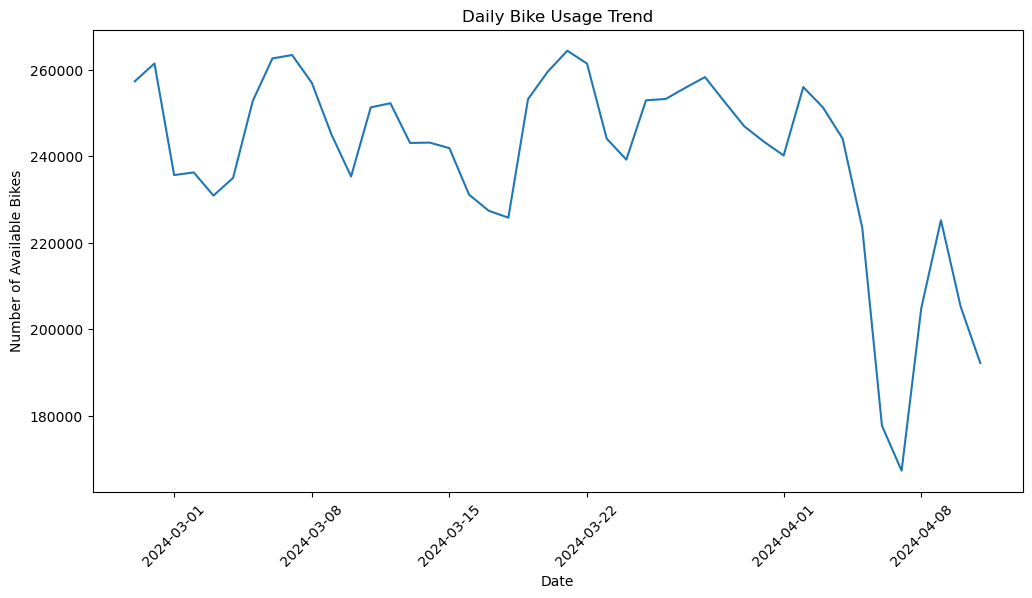

In [22]:
# Chart the trend of bicycle usage by day
df_combined['date'] = df_combined['last_update'].dt.date
daily_bikes = df_combined.groupby('date')['available_bikes'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='available_bikes', data=daily_bikes)
plt.title('Daily Bike Usage Trend')
plt.xlabel('Date')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()

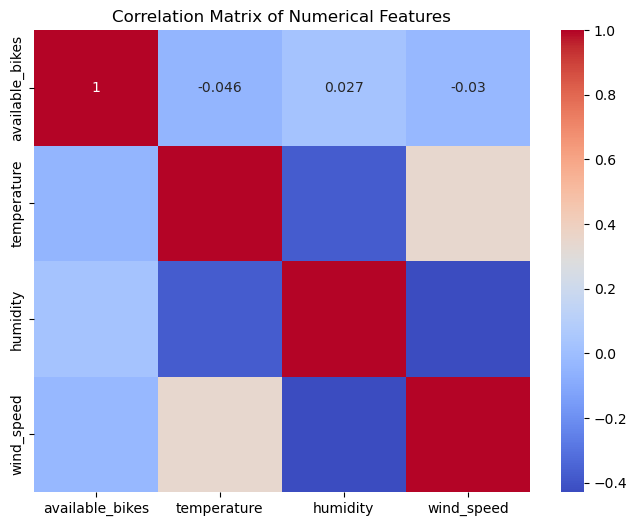

In [23]:
# Calculate correlations between numerical variables
correlation_matrix = df_combined[['available_bikes', 'temperature', 'humidity', 'wind_speed']].corr()

# Draw a correlation heat map
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


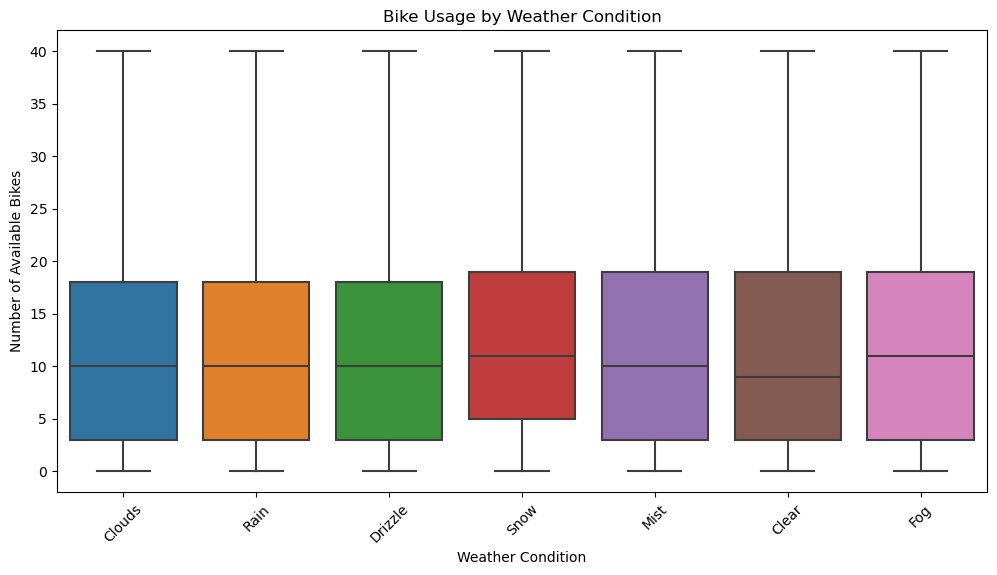

In [24]:
# Analyze bicycle usage in different weather conditions
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather_main', y='available_bikes', data=df_combined)
plt.title('Bike Usage by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Available Bikes')
plt.xticks(rotation=45)
plt.show()


Temperature and bike usage

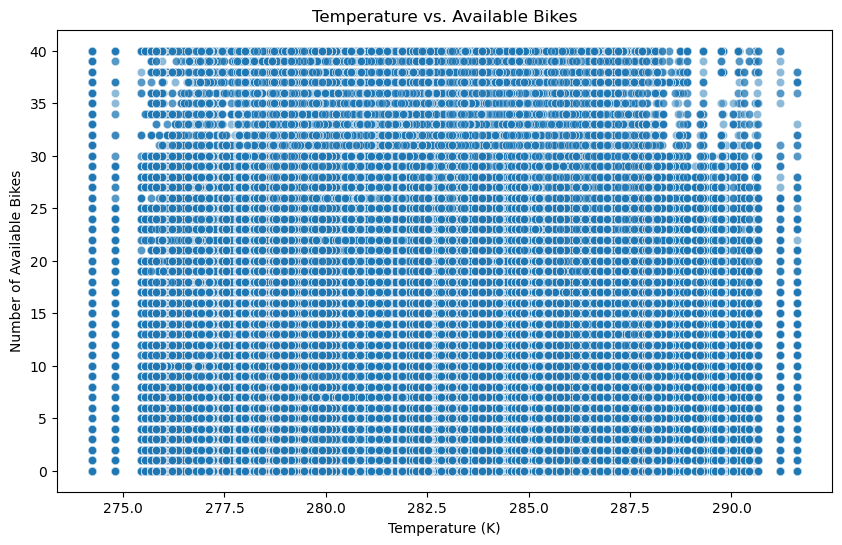

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Temperature vs. Available Bikes')
plt.xlabel('Temperature (K)')
plt.ylabel('Number of Available Bikes')
plt.show()


Humidity and bike usage

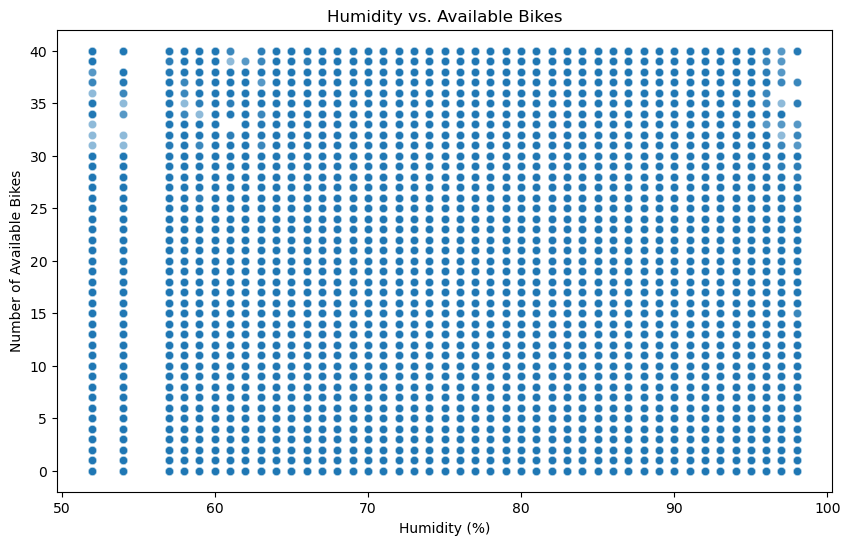

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='humidity', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Humidity vs. Available Bikes')
plt.xlabel('Humidity (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


Wind speed and bicycle usage
Assess the relationship between wind speed and bicycle use to determine whether strong winds reduce bicycle use.

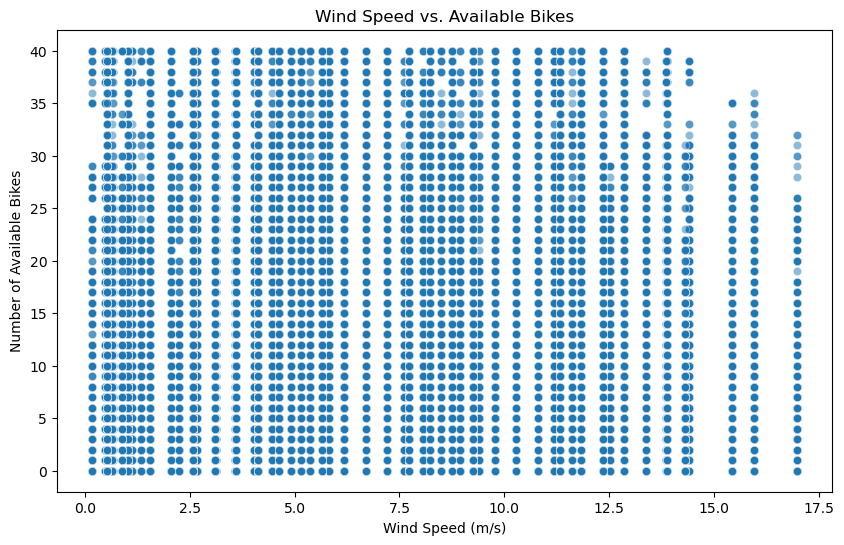

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='wind_speed', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Wind Speed vs. Available Bikes')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Number of Available Bikes')
plt.show()


Cloud cover and bicycle usage
Explore the relationship between cloud cover and bike usage to see how people tend to use their bikes on cloudy or sunny days.

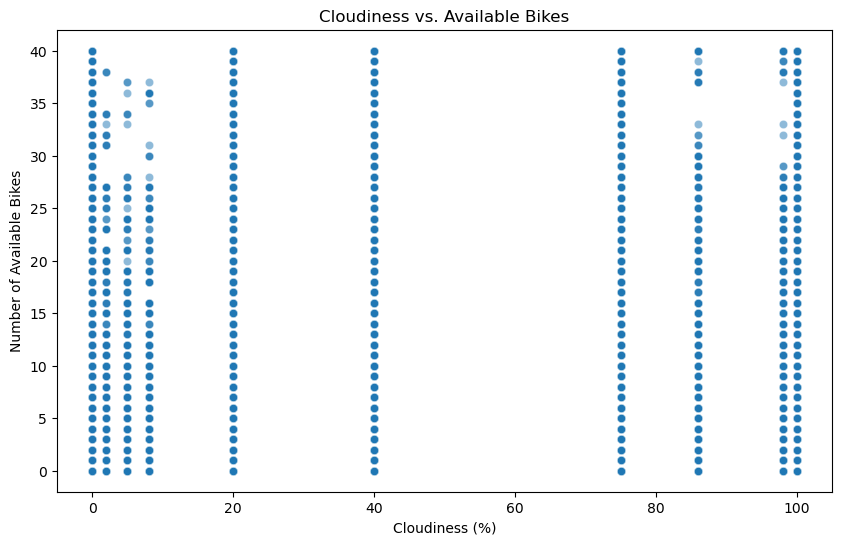

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='clouds_all', y='available_bikes', data=df_combined, alpha=0.5)
plt.title('Cloudiness vs. Available Bikes')
plt.xlabel('Cloudiness (%)')
plt.ylabel('Number of Available Bikes')
plt.show()


### Feature engineering

In [29]:
# Extract the time feature from the last_update
df_combined['hour'] = df_combined['last_update'].dt.hour
df_combined['day_of_week'] = df_combined['last_update'].dt.dayofweek
df_combined['is_weekend'] = df_combined['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_combined['is_peak_hour'] = df_combined['hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)


In [30]:
one_hot = OneHotEncoder()
weather_main_encoded = one_hot.fit_transform(df_combined[['weather_main']]).toarray()
weather_columns = one_hot.get_feature_names_out(['weather_main'])
df_weather_encoded = pd.DataFrame(weather_main_encoded, columns=weather_columns)
with open('one_hot_encoder.pickle', 'wb') as file:
    pickle.dump(one_hot, file)

In [31]:
df_combined = pd.concat([df_combined.reset_index(drop=True), df_weather_encoded.reset_index(drop=True)], axis=1)

In [32]:
df_combined['feels_like_temp'] = df_combined['temperature'] - ((100 - df_combined['humidity']) / 5)

In [33]:
print(df_combined.info())
print(df_combined.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880007 entries, 0 to 880006
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   number                 880007 non-null  int64         
 1   available_bikes        880007 non-null  int64         
 2   available_bike_stands  880007 non-null  int64         
 3   last_update            880007 non-null  datetime64[ns]
 4   temperature            880007 non-null  float64       
 5   feels_like             880007 non-null  float64       
 6   pressure               880007 non-null  float64       
 7   humidity               880007 non-null  float64       
 8   visibility             880007 non-null  float64       
 9   wind_speed             880007 non-null  float64       
 10  wind_deg               880007 non-null  float64       
 11  clouds_all             880007 non-null  float64       
 12  weather_main           880007 non-null  obje

### Model and Prediction

In [34]:
# Prepare feature matrix X and target variables y, retaining station numbers for association with specific stations post-prediction
X = df_combined.drop(['available_bikes', 'available_bike_stands', 'last_update', 'weather_main', 'weather_description'], axis=1)
X = X.select_dtypes(include=[np.number])  # Ensure only numeric columns are included

# Target variables
y_bikes = df_combined['available_bikes']
y_stands = df_combined['available_bike_stands']

# Dataset splitting
X_train_bikes, X_test_bikes, y_train_bikes, y_test_bikes = train_test_split(X, y_bikes, test_size=0.2, random_state=42)
X_train_stands, X_test_stands, y_train_stands, y_test_stands = train_test_split(X, y_stands, test_size=0.2, random_state=42)

# Train Decision Tree models
dt_bikes = DecisionTreeRegressor(random_state=42)
dt_bikes.fit(X_train_bikes, y_train_bikes)
dt_stands = DecisionTreeRegressor(random_state=42)
dt_stands.fit(X_train_stands, y_train_stands)

# Append station numbers to test data
test_data_bikes = X_test_bikes.copy()
test_data_bikes['number'] = df_combined.loc[X_test_bikes.index, 'number']
test_data_stands = X_test_stands.copy()
test_data_stands['number'] = df_combined.loc[X_test_stands.index, 'number']

# Perform predictions
y_pred_bikes_dt = dt_bikes.predict(X_test_bikes)
y_pred_stands_dt = dt_stands.predict(X_test_stands)

# Add predicted results to test data
test_data_bikes['predicted_bikes'] = y_pred_bikes_dt
test_data_stands['predicted_stands'] = y_pred_stands_dt

# Output results for inspection
print(test_data_bikes[['number', 'predicted_bikes']])
print(test_data_stands[['number', 'predicted_stands']])

# Performance evaluation
rmse_bikes_dt = mean_squared_error(y_test_bikes, y_pred_bikes_dt, squared=False)
rmse_stands_dt = mean_squared_error(y_test_stands, y_pred_stands_dt, squared=False)

print(f"RMSE for available bikes prediction with Decision Tree: {rmse_bikes_dt:.2f}")
print(f"RMSE for available bike stands prediction with Decision Tree: {rmse_stands_dt:.2f}")

        number  predicted_bikes
336864      83        30.000000
315586      33        17.000000
340241      86        26.000000
255102     117         2.000000
522720      52         8.000000
...        ...              ...
659949     107         6.000000
683578      40         2.000000
39648        8        20.000000
451129      59         0.333333
483539      27         0.000000

[176002 rows x 2 columns]
        number  predicted_stands
336864      83         10.000000
315586      33          6.000000
340241      86         12.000000
255102     117         38.000000
522720      52         24.000000
...        ...               ...
659949     107         34.000000
683578      40         20.000000
39648        8         10.000000
451129      59         19.666667
483539      27         20.000000

[176002 rows x 2 columns]
RMSE for available bikes prediction with Decision Tree: 1.50
RMSE for available bike stands prediction with Decision Tree: 1.48


In [35]:
with open('dt_bikes_model.pickle', 'wb') as f:
    pickle.dump(dt_bikes, f)

with open('dt_stands_model.pickle', 'wb') as f:
    pickle.dump(dt_stands, f)